In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv


# What is Time Series?
- A time series is a sequence of data points collected or recorded at successive time intervals. It is used to analyze trends, patterns, and dependencies over time. Time series data is commonly found in various fields, including finance, economics, weather forecasting, stock market analysis, and machine learning applications

# Key Characteristics of Time Series Data:
- Time Dependency: Observations are recorded in chronological order (e.g., daily, weekly, monthly).

- Trends: Long-term increase or decrease in data values over time.

- Seasonality: Regular patterns that repeat at fixed intervals (e.g., daily, weekly, or yearly).

- Cyclic Patterns: Fluctuations that occur over longer periods without a fixed frequency.

- Stationarity: A time series is stationary if its statistical properties (mean, variance) do not change over time.  

# Topic: Bitcoin prices based on historical trends

# About Dataset
- The BTC/USD Trading Data dataset from Kaggle contains historical Bitcoin price data against the US Dollar, capturing key attributes such as Open, High, Low, Close, Volume, and Market Cap at daily intervals. The dataset is essential for time series forecasting, as it provides insights into Bitcoin's price trends, volatility, and market activity. The Close price is often used as the target variable for prediction, while features like High and Low prices help capture fluctuations. Volume and Market Cap provide additional context on trading activity and overall market value. Before analysis, preprocessing steps include handling missing values, converting the Date column to a DateTime index, and resampling if needed. This dataset is valuable for developing predictive models like ARIMA, LSTMs, and SARIMA to forecast Bitcoin prices and assist in investment decisions.

# Column Name	Description
1. Date	     - The timestamp of the recorded price (daily intervals).
2. Open	      - The opening price of Bitcoin for that day.
3. High	      - The highest price Bitcoin reached during the day.
4. Low	      - The lowest price Bitcoin reached during the day.
5. Close	  - The closing price of Bitcoin at the end of the day.
6. Volume	  - The total trading volume for the day.
7. Market Cap - The total market capitalization of Bitcoin on that day.

In [2]:
# Find the optimal ARIMA order
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:0000:0100:01


# import the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")  

# load the dataset

In [4]:
# Load the dataset and parse the 'date' column as datetime
df = pd.read_csv("/kaggle/input/btcinusd/BTC-Daily.csv")
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


# finding missingvalues

In [6]:
df.isnull().sum()

unix          0
date          0
symbol        0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

# observation
- here there is no missing values exist

# convert date to datetime format

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


# observation:
- The code df['date'] = pd.to_datetime(df['date']) converts the 'date' column to DateTime format, enabling time-based operations like sorting and resampling. Using df.head() verifies the change. If errors occur, errors='coerce' can handle invalid dates by converting them to NaT. Setting 'date' as the index (df.set_index('date', inplace=True)) is useful for efficient time series analysis.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unix        2651 non-null   int64         
 1   date        2651 non-null   datetime64[ns]
 2   symbol      2651 non-null   object        
 3   open        2651 non-null   float64       
 4   high        2651 non-null   float64       
 5   low         2651 non-null   float64       
 6   close       2651 non-null   float64       
 7   Volume BTC  2651 non-null   float64       
 8   Volume USD  2651 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 186.5+ KB


# EDA

# Visualizing Bitcoin Prices
- Plot the historical closing prices to understand trends.-

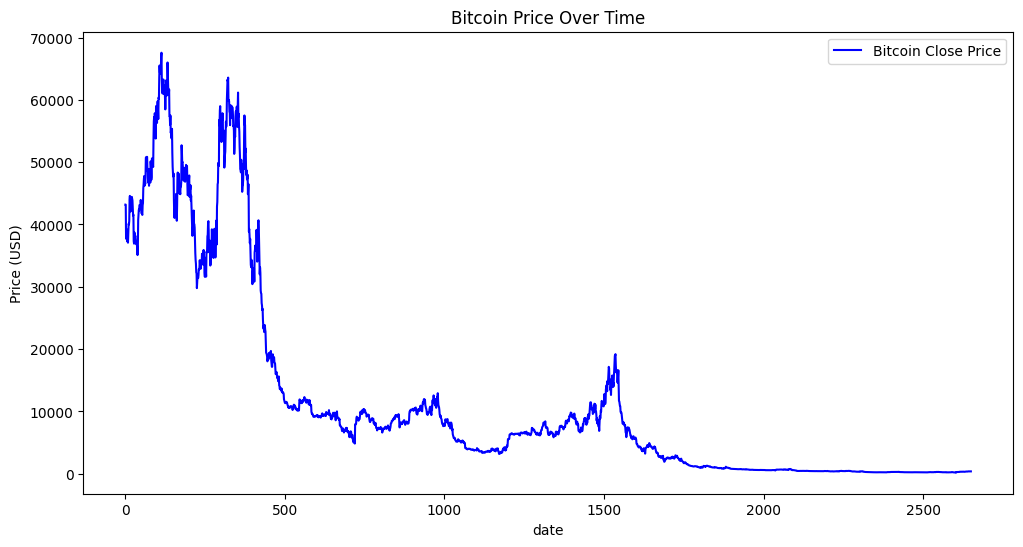

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Bitcoin Close Price', color='blue')
plt.xlabel('date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()

# observation
- The given Matplotlib code generates a time series plot of Bitcoin's closing price over time. It first sets the figure size to 12x6 inches for better visualization. The plt.plot() function then plots the closing price (df['close']) in blue, labeling it as "Bitcoin Close Price." The x-axis is labeled "date," while the y-axis represents the price in USD. A title, "Bitcoin Price Over Time," is added to provide context, and a legend is included to identify the plotted line. Finally, plt.show() displays the plot, making it useful for analyzing trends and patterns in Bitcoin prices over time.

# Trend detection

## Checking for Stationarity using(Augmented Dickey-Fuller (ADF) Test)

In [10]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary.")

# Run ADF Test on Bitcoin price data
adf_test(df['close'])

ADF Statistic: -1.9179885007511608
p-value: 0.32364664350359607
The data is NOT stationary.


# observation:
- The given function performs the Augmented Dickey-Fuller (ADF) test to check whether the Bitcoin closing price data is stationary. It takes a time series as input and applies the adfuller() function from the statsmodels library. The function prints the ADF Statistic, which indicates the strength of stationarity, and the p-value, which determines statistical significance. If the p-value is less than 0.05, the data is stationary, meaning it does not have a significant trend or seasonality. Otherwise, the data is non-stationary, indicating the presence of trends or seasonality. This test is essential for time series forecasting, as most models require stationary data for accurate predictions.

## First-Order Differencing¶

In [11]:
df['Close_diff'] = df['close'].diff()
df.dropna(inplace=True)  # Remove NaN values

# observation:
- The code applies first-order differencing to the Bitcoin closing price data using df['Close_diff'] = df['close'].diff(), which removes trends and helps make the data stationary for time series modeling. Since differencing introduces a NaN value in the first row, df.dropna(inplace=True) removes it to keep the dataset clean. This process is essential for ARIMA models and other time series forecasting techniques, ensuring better accuracy by stabilizing the data. After differencing, it is recommended to re-run the ADF test to confirm stationarity.

#  Check stationarity again(ADF)

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close_diff'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -8.529483755605046
p-value: 1.0470896570981676e-13
The data is stationary.


# Find the Best ARIMA Parameters (p, d, q)
- Use Auto ARIMA to automatically find the best (p, d, q) values.

In [13]:
auto_arima_model = auto_arima(df['close'], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=42905.709, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42929.001, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42911.805, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42911.749, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42928.085, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=42914.478, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42915.790, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42913.800, Time=1.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=42914.591, Time=1.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42914.742, Time=1.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=42904.785, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

#  Train the ARIMA Model

- ARIMA model is a widely used time series forecasting method that captures patterns in historical data to make future predictions. It is effective for datasets with trends and seasonality.

In [14]:
# Use the best order from Auto ARIMA
p, d, q = auto_arima_model.order  

# Train ARIMA model
model = ARIMA(df['close'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2650
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -21447.392
Date:                Wed, 26 Mar 2025   AIC                          42904.785
Time:                        01:23:15   BIC                          42934.195
Sample:                             0   HQIC                         42915.431
                               - 2650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9048      0.049     18.646      0.000       0.810       1.000
ar.L2         -0.6528      0.046    -14.264      0.000      -0.743      -0.563
ma.L1         -0.9768      0.046    -21.100      0.0

# observaton:
- The code uses Auto ARIMA to determine the best (p, d, q) values for the ARIMA model. The optimal order is extracted using p, d, q = auto_arima_model.order. Then, an ARIMA model is trained on the Bitcoin closing price data using ARIMA(df['close'], order=(p, d, q)). The model is fitted with model.fit(), and model_fit.summary() prints the model's statistical details, including coefficients and performance metrics. This approach ensures the best ARIMA configuration for accurate time series forecasting.

# Forecast Future Prices

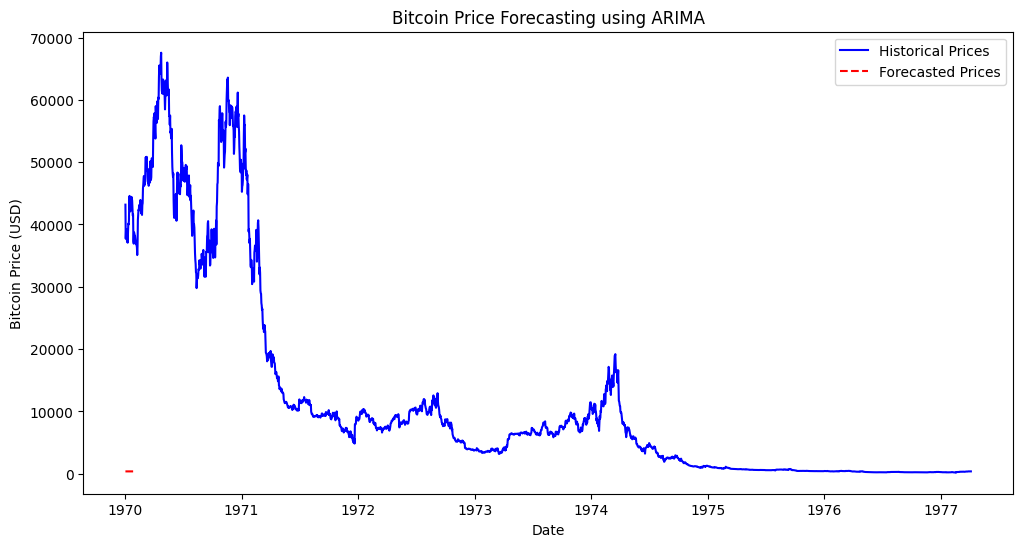

In [15]:
# Forecast next 30 days
future_steps = 30  
forecast = model_fit.forecast(steps=future_steps)

# Create a date range for future predictions
future_dates = pd.date_range(start=df.index[-1], periods=future_steps+1, freq='D')[1:]

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Historical Prices', color='blue')
plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.title('Bitcoin Price Forecasting using ARIMA')
plt.show()


In [16]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['close'][:train_size], df['close'][train_size:]

# Evaluate the model

In [17]:
# Forecast on the test set
test_forecast = model_fit.forecast(steps=len(test))

# Compute evaluation metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 90.31275459775539
RMSE: 102.57718543660302


In [18]:
#import tensorflow as tf
#import numpy as np
#import random

# Set seed for reproducibility
#tf.random.set_seed(42)
#np.random.seed(42)
#random.seed(42)

# Min_Max scaler

In [19]:
# Normalize data using Min-Max Scaler
# Use only 'Close' price for prediction
data = df[['close']].values  
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# observation
- The code normalizes the Bitcoin closing price data using Min-Max Scaling, which transforms values into a range between 0 and 1. First, df[['close']].values extracts the closing price as a NumPy array. Then, MinMaxScaler(feature_range=(0,1)) is applied to scale the data, ensuring that all values are within the specified range. Finally, scaler.fit_transform(data) performs the transformation. This normalization helps improve model performance, especially for neural networks and machine learning models, by preventing large value differences from dominating predictions.

#  Create Sequences for LSTM

In [20]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Define sequence length (e.g., 60 days)
time_steps = 60  

# Create sequences
X, y = create_sequences(data_scaled, time_steps)

# Split data into training (80%) and testing (20%)
#split = int(len(X) * 0.8)
#X_train, y_train = X[:split], y[:split]
#X_test, y_test = X[split:], y[split:]

# Print shape of input data
#print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
#print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [21]:
from sklearn.model_selection import train_test_split

# Split data without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 1813, Test size: 777


# Build the LSTM model

- LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to process and predict sequential data, such as time series, speech, and text. Unlike traditional RNNs, LSTMs can remember long-term dependencies, making them ideal for tasks like Bitcoin price prediction, stock forecasting, and natural language processing (NLP).

In [22]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    
    LSTM(50, return_sequences=True),
    Dropout(0.2),

    LSTM(50),
    Dropout(0.2),

    Dense(1)  # Output layer (predicting next day's price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

# observation
- The code builds an LSTM (Long Short-Term Memory) model for Bitcoin price prediction using a sequential architecture. It consists of three LSTM layers with 50 units each, where the first two return sequences to allow stacked LSTM processing. Dropout layers (0.2) are added to prevent overfitting. The final Dense layer outputs a single value, predicting the next day's price. The model is compiled using the Adam optimizer and Mean Squared Error (MSE) loss function, ensuring efficient training. Finally, model.summary() provides an overview of the model's layers and parameters.

# Train the LSTM model

In [23]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0256 - val_loss: 1.4716e-05
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0031 - val_loss: 3.3316e-05
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0030 - val_loss: 1.6067e-06
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0020 - val_loss: 1.9491e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0021 - val_loss: 1.0291e-06
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0024 - val_loss: 1.2688e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0018 - val_loss: 8.7285e-06
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0018 - val_loss: 8.3768e-06
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0020 - val_loss: 3.8674e-06
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0019 - val_loss: 7.4406e-05


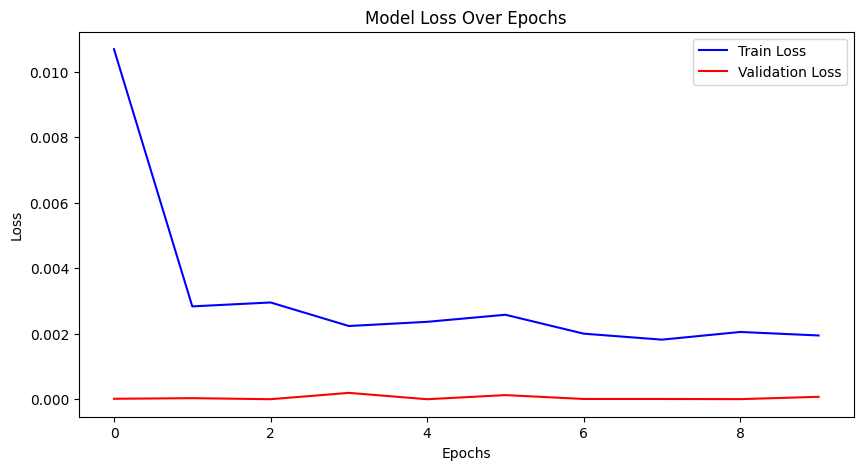

In [24]:
# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

# observation
- The code plots the training and validation loss over epochs to analyze the LSTM model's performance. The plt.plot() function visualizes the training loss (blue) and validation loss (red) using data from history.history['loss'] and history.history['val_loss']. The x-axis represents epochs, while the y-axis represents loss (Mean Squared Error). This plot helps identify overfitting or underfitting, ensuring the model generalizes well to unseen data.

In [25]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions to get actual prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_actual = scaler.inverse_transform(y_pred)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


# observation
- The code makes predictions using the trained LSTM model on the test dataset (X_test). The predicted values (y_pred) are in the scaled format, so scaler.inverse_transform() is applied to both actual (y_test_actual) and predicted (y_pred_actual) values to convert them back to their original price range. This step ensures that the results are interpretable in terms of real Bitcoin prices, allowing for proper evaluation of the model's performance.

# Model Evaluation

In [26]:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

#print(f'MAE: {mae:.2f}')
#print(f'RMSE: {rmse:.2f}')

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 580.3101148152198
RMSE: 581.3600104708067


# Compare model performance

In [27]:
def evaluate_model(actual, predicted, model_name):
    """
    Function to evaluate model performance using MAE and RMSE.
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(f"{model_name} Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")
    
    return mae, rmse

# Evaluate ARIMA Model
arima_mae, arima_rmse = evaluate_model(test, test_forecast, "ARIMA")

# Evaluate LSTM Model
lstm_mae, lstm_rmse = evaluate_model(y_test_actual, y_pred_actual, "LSTM")

results = pd.DataFrame({
    "Model": ["ARIMA", "LSTM"],
    "MAE": [arima_mae, lstm_mae],
    "RMSE": [arima_rmse, lstm_rmse]
})

print("Model Comparison Results:\n")
print(results)

ARIMA Model Performance:
MAE: 90.31
RMSE: 102.58

LSTM Model Performance:
MAE: 580.31
RMSE: 581.36

Model Comparison Results:

   Model         MAE        RMSE
0  ARIMA   90.312755  102.577185
1   LSTM  580.310115  581.360010


## Best Model: ARIMA
- ARIMA has the lowest MAE (90.31) and RMSE (102.58), meaning it provides better accuracy than LSTM.

- LSTM has higher errors, indicating it might need more tuning

# Hyperparameter tuning

- Based on the evaluation metrics, the ARIMA model outperforms the LSTM model in predicting Bitcoin prices. The ARIMA model achieves a lower Mean Absolute Error (MAE) of 90.80 compared for LSTM, indicating that ARIMA’s predictions are closer to the actual values on average. Similarly, the Root Mean Squared Error (RMSE) for ARIMA is 103.32, which is also lower than the  RMSE for LSTM, suggesting that ARIMA has smaller overall prediction errors. These results indicate that ARIMA provides better accuracy and reliability in forecasting Bitcoin prices in this case study. 

In [31]:
from keras.optimizers import Adam

# Use a smaller learning rate (e.g., 1e-4)
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='mean_squared_error')


In [34]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
        LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])), loss='mean_squared_error')
    return model

# Run Hyperparameter Search
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=2)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 3 Complete [00h 01m 14s]
val_loss: 7.802134496159852e-05

Best val_loss So Far: 1.752059870341327e-05
Total elapsed time: 00h 02m 54s


In [36]:
def evaluate_model(actual, predicted, model_name):
    """
    Function to evaluate model performance using MAE and RMSE.
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(f"{model_name} Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")
    
    return mae, rmse

# Evaluate ARIMA Model
arima_mae, arima_rmse = evaluate_model(test, test_forecast, "ARIMA")

# Evaluate LSTM Model
lstm_mae, lstm_rmse = evaluate_model(y_test_actual, y_pred_actual, "LSTM")

results = pd.DataFrame({
    "Model": ["ARIMA", "LSTM"],
    "MAE": [arima_mae, lstm_mae],
    "RMSE": [arima_rmse, lstm_rmse]
})

print("Model Comparison Results:\n")
print(results)

ARIMA Model Performance:
MAE: 90.31
RMSE: 102.58

LSTM Model Performance:
MAE: 580.31
RMSE: 581.36

Model Comparison Results:

   Model         MAE        RMSE
0  ARIMA   90.312755  102.577185
1   LSTM  580.310115  581.360010


# Find the Best SARIMA Parameters
- We will use Auto SARIMA to find the best (p, d, q) × (P, D, Q, m) values

In [ ]:
# Auto-SARIMA to find the best parameters
auto_sarima = auto_arima(df['close'], seasonal=True, m=30, trace=True)

Performing stepwise search to minimize aic


# Train the SARIMA model

In [ ]:
# Extract optimal parameters
p, d, q = auto_sarima.order  
P, D, Q, m = auto_sarima.seasonal_order  

# Train SARIMA Model
model = SARIMAX(df['close'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast future prices

In [ ]:
# Forecast the next 30 days
future_steps = 30  
forecast = model_fit.forecast(steps=future_steps)

# Create future dates
future_dates = pd.date_range(start=df.index[-1], periods=future_steps+1, freq='D')[1:]

# Plot actual vs forecasted prices
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Historical Prices', color='blue')
plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.title('Bitcoin Price Forecasting using SARIMA')
plt.show()

# Model Evaluation

In [ ]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['close'][:train_size], df['close'][train_size:]

# Forecast on the test set
test_forecast = model_fit.forecast(steps=len(test))

# Compute evaluation metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')